In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from data_loader import data_loader
import datetime

import model as Model
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [221]:
# load dataset
batch_size = 50
lr = 0.001
head = 1
root = 'E:'
gen = True
meta = False
audio = "musicnn"
#audio = None
#lyric = "tf_idf"
lyric = None
sub = False

loss_type = 'seq_cos'
seq_k = 10

use_music_embedding = False
check_baseline = False

echo_nest_sub_path = 'dataset/echo_nest/sub_data'
echo_nest_whole_path = 'dataset/echo_nest/data'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get task name from args configurations
def get_task_name(genre=False, meta=True, audio='musicnn', lyric=None):
    task_name = ""
    if genre is True:
        task_name += "genre_"
    if meta is True:
        task_name += "meta_"
    if audio is None:
        task_name += "none" + '_'
    else:
        task_name += audio + '_'
    if lyric is None:
        task_name += "none"
    else:
        task_name += lyric
    return task_name

# get sub task name for sub-folder
def get_sub_task_name(batch, lr, head):
    return "b_{}_lr_{}_head_{}".format(batch, lr, head)

# load batch size and learning rate
learning_rate = lr
# check if it is a sub-dataset for debugging and testing
if sub:
    work_folder_root = root + '/' + echo_nest_sub_path
else:
    work_folder_root = root + '/' + echo_nest_whole_path
# create work folder
task_name = get_task_name(gen, meta, audio, lyric)
work_folder = work_folder_root + '/' + task_name
if not os.path.exists(work_folder):
    os.makedirs(work_folder)
# create cache folder
cache_folder = work_folder + '/cache'
if not os.path.exists(cache_folder):
    os.makedirs(cache_folder)

dataset = data_loader.Dataset(dataset_root='E:', sub=sub, genre=gen, meta=meta, \
        audio=audio, lyric=lyric, outdir=cache_folder, dim_list=[0, 0, 200, 0])

music_embed_dim, music_embed_dim_list = dataset.get_dim()
print("dataset loaded:")
print("music embed dim: {} [{}, {}, {}, {}]".format(music_embed_dim, music_embed_dim_list[0], \
    music_embed_dim_list[1], music_embed_dim_list[2], music_embed_dim_list[3]))

# load train and valid set
train_data_list = dataset.get_data(set_tag='train', neg_samp=False)
x_train_len_list, y_train_len_list, x_train_tensor_list, y_train_tensor_list = \
    dataset.get_batched_data(train_data_list, batch_size=batch_size, fix_length=False)
x_train_tracks = train_data_list[2]
y_train_tracks = train_data_list[3]

valid_data_list = dataset.get_data(set_tag='valid', neg_samp=False)
# valid_data_batch =  len(valid_data_list[0])
valid_data_batch = batch_size
x_valid_len_list, y_valid_len_list, x_valid_tensor_list, y_valid_tensor_list = \
    dataset.get_batched_data(valid_data_list, batch_size=valid_data_batch, fix_length=False)
x_valid_tracks = valid_data_list[2]
y_valid_tracks = valid_data_list[3]

# load test set
test_data_dict = dataset.get_data(set_tag='test')
test_data_batch = batch_size
test_batched_data_dict = {}
x_test_tracks_dict = {}
y_test_tracks_dict = {}
for key in test_data_dict.keys():
    x_test_len_list, y_test_len_list, x_test_tensor_list, y_test_tensor_list = \
        dataset.get_batched_data(test_data_dict[key], batch_size=test_data_batch, fix_length=False)
    test_batched_data_dict[key] = [x_test_len_list, y_test_len_list, x_test_tensor_list, y_test_tensor_list]
    print("{} playlists found for {}".format(len(x_test_len_list) * test_data_batch, key))
    x_test_tracks_dict[key] = test_data_dict[key][2]
    y_test_tracks_dict[key] = test_data_dict[key][3]
    
# load model
model = Model.UserAttention(music_embed_dim, music_embed_dim_list, \
    return_seq=True if loss_type=='seq_cos' else False, seq_k=seq_k, re_embed=use_music_embedding, \
    check_baseline=check_baseline)

# load checkpoint
# check if checkpoint exists
sub_task_name = get_sub_task_name(batch_size, lr, head)
checkpoint_final_path = work_folder + '/' + sub_task_name + '.pt'
if os.path.isfile(checkpoint_final_path):
    checkpoint = torch.load(checkpoint_final_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    best_valid_loss = checkpoint['valid_loss']
    print("Checkpoint found, start from epoch {}, loss: {}, valid loss:{}"\
        .format(start_epoch, loss, best_valid_loss))

# move model to device
model = nn.DataParallel(model) # designed for multi-GPUs
model = model.to(device)

# load recommender
if loss_type == 'seq_cos':
    recommender_valid = Model.MusicRecommenderSequenceEmbed(dataset, device, mode='train', \
        model=model, use_music_embedding=use_music_embedding)
else:
    recommender_valid = Model.MusicRecommender(dataset, device, mode='train', model=model, \
        use_music_embedding=use_music_embedding)

if loss_type == 'seq_cos':
    recommender_test = Model.MusicRecommenderSequenceEmbed(dataset, device, mode='test', \
        model=model, use_music_embedding=use_music_embedding)
else:
    recommender_test = Model.MusicRecommender(dataset, device, mode='test', model=model, \
        use_music_embedding=use_music_embedding)

Load existed song dictionary cache successfully!
Load existed genre dictionary cache successfully!
Load existed genre matrix cache successfully!
Load existed audio feature matrix cache successfully!
Load existed song matrix cache successfully!
Load existed train song dictionary and matrix cache successfully!
Load existed test song dictionary and matrix cache successfully!
Load existed train matrix cache successfully!
Load existed valid matrix cache successfully!
Load existed test matrix cache successfully!
dataset loaded:
music embed dim: 401 [201, 0, 200, 0]
950 playlists found for item_cold
300 playlists found for user_cold_10
50 playlists found for user_cold_25
850 playlists found for user_cold_5
950 playlists found for user_item_cold
Checkpoint found, start from epoch 24, loss: 0.003927995419094089, valid loss:0.014580598834524061
52419 songs in test set: old: 44083 (84.0973692744997%) ,new: 8336 (15.902630725500297%)


In [230]:
# visualize user embedding, user liked songs, and song embedding distribution
class Visualizer(object):
    
    def __init__(self, dataset):
        self.song_mat = dataset.song_mat
        # pca song mat to 2d
        U, S, self.V = torch.pca_lowrank(torch.tensor(self.song_mat), q=2)
        #self.song_mat = torch.matmul(torch.tensor(self.song_mat), self.V[:, :2]).numpy()
        self.song_mat = self.to_2d(self.song_mat)
        self.V = self.V.to(torch.float32)
        print("Visualizer init")
        
    def to_2d(self, mat):
        mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()
        # standardize
        mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)
        return mat
    
    def evaluate(self, model, x_tensor_list, y_tensor_list, x_len_list, y_len_list, x_tracks, y_tracks, recommender):
        self.x = x_tensor_list
        self.y = y_tensor_list
        self.x_track = x_tracks
        self.y_track = y_tracks
        self.pred_list = []
        self.recom_list = []
        self.recom_id_list = []
        self.recall_list = []
        self.matched_list = []
        # check mode
        mode = recommender.mode
        #for i in tqdm(range(len(x_tensor_list))):
        for i in tqdm(range(2)):
            # get x and y
            x = x_tensor_list[i].to(device)
            x_len = x_len_list[i]
            y = y_tensor_list[i].to(device)
            y_len = y_len_list[i]
            _batch_size = x.shape[0]
            # generate mask for attention
            x_mask = Model.generate_mask(x_len).to(device)
            # generate mask for y to calculate loss
            y_mask = Model.generate_out_mask(y_len).to(device)
            x_y_mask = Model.generate_out_mask(x_len).to(device)
            # set to evaluation
            model.eval()
            # prediction
            pred = model(x, x_mask)
            self.pred_list.append(pred)
            # recommendation
            if mode == 'train':
                top_10_track_ids, top_10_track_mats, recalls, others = \
                    recommender.recommend(pred, x_tracks[i * _batch_size: (i + 1)*_batch_size], y_tracks[i * _batch_size: (i + 1)*_batch_size], return_songs=True)
                self.recom_list.append(top_10_track_mats)
                self.recom_id_list.append(top_10_track_ids)
            elif mode == 'test':
                top_10_track_ids, top_10_track_mats, recalls, recalls_old, recalls_new, others = \
                    recommender.recommend(pred, x_tracks[i * _batch_size: (i + 1)*_batch_size], y_tracks[i * _batch_size: (i + 1)*_batch_size], return_songs=True)
                self.recom_list.append(top_10_track_mats)
                self.recom_id_list.append(top_10_track_ids)
            # recall 100 for each user
            for u in range(batch_size):
                # get recalls for the user
                top_k_track = set(self.recom_id_list[i][2*u])
                gt_set = set(self.y_track[i * batch_size + u])
                inter_set = top_k_track & gt_set
                self.recall_list.append(len(inter_set) / len(gt_set))
                self.matched_list.append(list(inter_set))
            
                
    def visualize(self, idx, user_embed_num=10):
        batch_idx, user_idx = int(idx / batch_size), idx - int(idx / batch_size) * batch_size
        #user_embed = self.pred_list[batch_idx][user_idx].to('cpu').detach().numpy()
        #liked_song = self.x[batch_idx][user_idx].to('cpu').detach().numpy()
        #masked_song = self.y[batch_idx][user_idx].to('cpu').detach().numpy()
        user_embed = self.pred_list[batch_idx][user_idx].to('cpu').to(torch.float32)
        liked_song = self.x[batch_idx][user_idx].to('cpu').to(torch.float32)
        masked_song = self.y[batch_idx][user_idx].to('cpu').to(torch.float32)
        # To 2d
        user_embed = self.to_2d(user_embed)
        liked_song = self.to_2d(liked_song)
        masked_song = self.to_2d(masked_song)
        # get recalls for the user
        print('user id: {}, recalls: @100: {}, matched: {} / {}'\
              .format(idx, self.recall_list[idx], len(self.matched_list[idx]), len(self.y_track[idx])))
        # standardize
        plt.figure()
        #plt.scatter(user_embed[:, 0], user_embed[:, 1], label='user embedding')
        if user_embed_num > 0:
            plt.plot([0, user_embed[0, 0]], [0, user_embed[0, 1]], color='steelblue', label='user embedding')
        for j in range(1, user_embed_num):
            #print(user_embed[j, 0],user_embed[j, 1])
            plt.plot([0, user_embed[j, 0]], [0, user_embed[j, 1]], color='steelblue')
        plt.scatter(liked_song[:, 0], liked_song[:, 1], label='liked songs', color='seagreen')
        plt.scatter(masked_song[:, 0], masked_song[:, 1], label='masked songs', color='orange')
        plt.axis('equal')
        plt.legend()
        plt.show()
        
        
            
visual = Visualizer(dataset)
visual.evaluate(model, x_valid_tensor_list, y_valid_tensor_list, x_valid_len_list, y_valid_len_list, x_valid_tracks, y_valid_tracks, recommender_valid)


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Visualizer init


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.35s/it]


(-1.0242837608046125,
 -0.49004102308337977,
 -0.9254919249481209,
 0.5682297438383432)

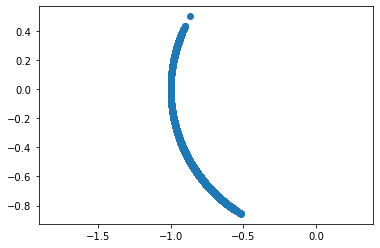

In [231]:
# visualize song mat
plt.scatter(visual.song_mat[:, 0], visual.song_mat[:, 1])
plt.axis('equal')

[ 0 34 28 42 25 43 47 50 21 59 60 18 61 16 32 31 69 12 70 73 74 76 77 83
 84 93 96  2  1 64 15 35 49  9 23 40 53  6 11 14 36 39 17 67 45 85 52 33
 29 26 27 57 65 68 95 97 41  3 54  4 10 19 72 48 44 98 79 99 91  7 55 30
 24 86 62 13  5 22  8 71 51 90 87 66 81 80 94 88 20 38 37 78 92 58 63 82
 75 89 46 56]
27
top_k: [56 46 89 75 82 63 58 92 78 37 38 20 88 94 80 81 66 87 90 51]
bottom_k: [ 0 34 28 42 25 43 47 50 21 59 60 18 61 16 32 31 69 12 70 73]
Recall = 0:  31.0 31.0%
Recall > 0:  69.0 69.0%
0.1519391383587667


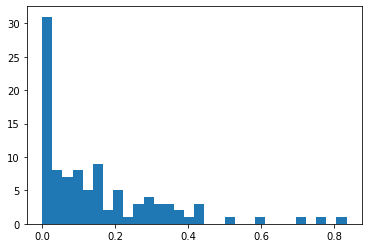

In [233]:
k = 20

args = np.argsort(np.array(visual.recall_list))

print(args)
print(args[int(len(args) / 2)])

top_k_arg = args[-k:]
bottom_k_arg = args[:k]
print('top_k:', np.flip(top_k_arg))
print('bottom_k:', bottom_k_arg)

num = plt.hist(visual.recall_list, bins=30)
print('Recall = 0: ', num[0][0], "{}%".format(num[0][0] * 100 / (num[0][0] + num[0][1:].sum())))
print('Recall > 0: ',num[0][1:].sum(), "{}%".format(num[0][1:].sum() * 100 / (num[0][0] + num[0][1:].sum())))
print(sum(visual.recall_list)/len(visual.recall_list))

<ipython-input-222-42f083d9388b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()
<ipython-input-222-42f083d9388b>:16: RuntimeWarning: invalid value encountered in true_divide
  mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)


user id: 46, recalls: @100: 0.7692307692307693, matched: 10 / 13


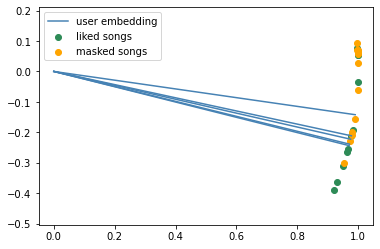

user id: 56, recalls: @100: 0.8333333333333334, matched: 20 / 24


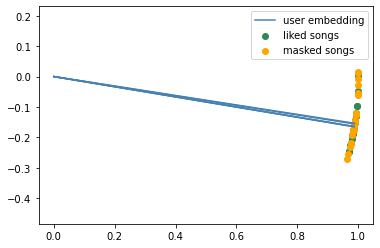

user id: 99, recalls: @100: 0.16666666666666666, matched: 4 / 24


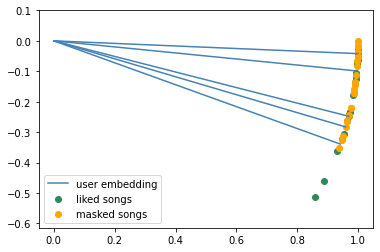

user id: 91, recalls: @100: 0.17857142857142858, matched: 5 / 28


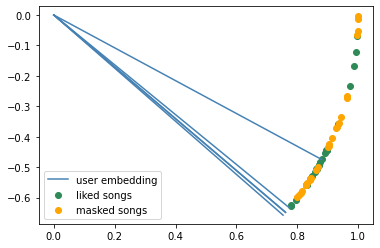

user id: 0, recalls: @100: 0.0, matched: 0 / 11


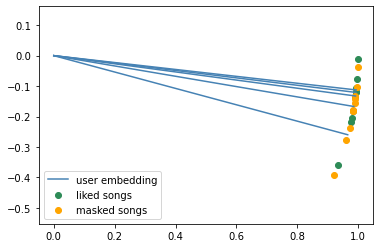

user id: 61, recalls: @100: 0.0, matched: 0 / 9


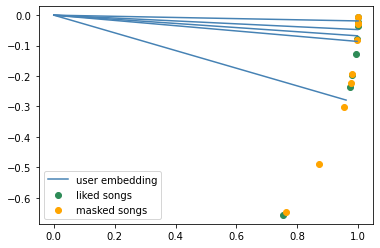

'\nvisual.visualize(89, user_embed_num=embed_num)\nvisual.visualize(5, user_embed_num=embed_num)\n\nvisual.visualize(95, user_embed_num=embed_num)\nvisual.visualize(94, user_embed_num=embed_num)\n\nvisual.visualize(0, user_embed_num=embed_num)\nvisual.visualize(64, user_embed_num=embed_num)\n'

In [225]:
embed_num = 5

# genre + audio
visual.visualize(46, user_embed_num=embed_num)
visual.visualize(56, user_embed_num=embed_num)

visual.visualize(99, user_embed_num=embed_num)
visual.visualize(91, user_embed_num=embed_num)

visual.visualize(0, user_embed_num=embed_num)
visual.visualize(61, user_embed_num=embed_num)

# lyric
'''
visual.visualize(91, user_embed_num=embed_num)
visual.visualize(67, user_embed_num=embed_num)

visual.visualize(31, user_embed_num=embed_num)
visual.visualize(30, user_embed_num=embed_num)

visual.visualize(0, user_embed_num=embed_num)
visual.visualize(71, user_embed_num=embed_num)
'''

# genre
'''
visual.visualize(46, user_embed_num=embed_num)
visual.visualize(56, user_embed_num=embed_num)

visual.visualize(99, user_embed_num=embed_num)
visual.visualize(91, user_embed_num=embed_num)

visual.visualize(0, user_embed_num=embed_num)
visual.visualize(61, user_embed_num=embed_num)
'''
# audio
'''
visual.visualize(89, user_embed_num=embed_num)
visual.visualize(5, user_embed_num=embed_num)

visual.visualize(95, user_embed_num=embed_num)
visual.visualize(94, user_embed_num=embed_num)

visual.visualize(0, user_embed_num=embed_num)
visual.visualize(64, user_embed_num=embed_num)
'''

In [132]:
len(visual.recom_id_list[0])

100

In [124]:
len(visual.y_track)

973

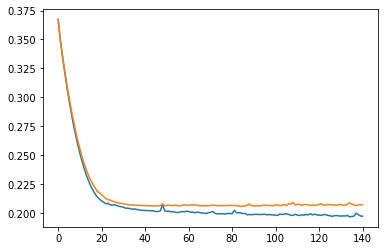

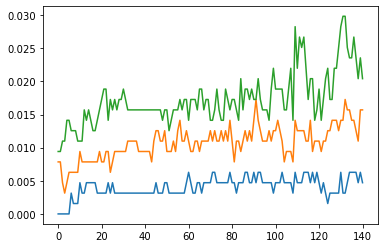

In [9]:
# visualize training process
pkl_path = 'E:\dataset\echo_nest\sub_data\genre_meta_musicnn_none\\b_50_lr_0.001_head_1.pkl'
with open(pkl_path, 'rb') as f:
    recorders = pickle.load(f)
    train_loss_batch = recorders['train_loss_batch']
    train_loss_epoch = recorders['train_loss_epoch']
    valid_loss_epoch = recorders['valid_loss_epoch']
    recall_epoch = recorders['recall_epoch']

plt.figure(1)
plt.plot(train_loss_epoch)
plt.plot(valid_loss_epoch)

recalls = np.array(recall_epoch)
plt.figure(2)
plt.plot(recalls[:, 0])
plt.plot(recalls[:, 1])
plt.plot(recalls[:, 2])